#Ecuadorian Network
Evaluation of data from Pypsa-Earth


In [81]:
"""
Setup environment and load the base PyPSA-Earth network for a specified country.
"""

import os
import sys
import warnings
import pypsa
import warnings
from pathlib import Path
import pypsa
import numpy as np
from pathlib import Path
import os
import shutil
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import requests
import matplotlib.patheffects as pe
from matplotlib.colors import LinearSegmentedColormap, to_hex
import copy
from os.path import join

# Import all dirs
parent_dir = Path(os.getcwd()).parents[0]
sys.path.append(str(parent_dir))
from src.paths import all_dirs

dirs = all_dirs()


import logging
from pathlib import Path

LOG_FILE = join(parent_dir, "logs.log")

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    handlers=[logging.FileHandler(LOG_FILE, encoding="utf-8")],
)


# Suppress warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)
# Suppress unnecessary warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# Define country parameters
country_code = "EC"  # ISO 2-letter code (e.g., 'GH' for Ghana, 'CO' for Colombia)
country_name = "Ecuador"  # Country name
country_gadm = "ECU"  # ISO 3-letter GADM code

# Load the base network file path
network_dir = dirs["data/processed/networks"]
network_files = [
    "network_original",
    "network_snapped",
    "network_expanded",
    "network_expanded_no_orphans",
    "network_nuclear",
    "network_prod_mix",
    "network_base",
]

networks_dict = {
    nf: pypsa.Network(join(network_dir, f"{nf}.nc")) for nf in network_files
}

#### Mapping buses and place of interest

In [82]:
# ---------------------------------------------------------------------
# GADM boundary data (expects `country_gadm` to be defined upstream, e.g., "ECU")
# ---------------------------------------------------------------------

# Where to put / find GADM (expects dirs["data/raw/gadm"])
COUNTRY_ISO3 = "ECU"
GADM_BASE_DIR = None  # will be inferred from dirs dict below
GADM_VERSION = "4.1"
GADM_FILE_STEM = f"gadm41_{COUNTRY_ISO3}"
GADM_LAYER_L1 = "ADM_ADM_1"
GADM_URL = f"https://geodata.ucdavis.edu/gadm/gadm{GADM_VERSION}/gpkg/{GADM_FILE_STEM}.gpkg"

def ensure_gadm_file(gadm_path: str) -> str:
    """Ensure GADM gpkg exists locally; download if missing. Return path to gpkg."""
    gpkg_path = os.path.join(gadm_path, f"{GADM_FILE_STEM}.gpkg")
    gpkg_dir = Path(gpkg_path).parent
    if not Path(gpkg_path).is_file():
        gpkg_dir.mkdir(parents=True, exist_ok=True)
        resp = requests.get(GADM_URL, stream=True, timeout=300)
        resp.raise_for_status()
        with open(gpkg_path, "wb") as f:
            shutil.copyfileobj(resp.raw, f)
    else:
        print(f"GADM file already exists: {gpkg_path}")
    assert Path(gpkg_path).is_file(), f"GADM file not found or failed to download: {gpkg_path}"
    return gpkg_path

GADM_inputfile_gpkg = ensure_gadm_file(dirs["data/raw/gadm"])


GADM file already exists: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\raw\gadm\gadm41_ECU.gpkg


In [83]:
def plot_buses_and_lines_by_voltage(
    network: pypsa.Network, title=None, save_name=None, bus_ids=False,
    lower_v_limit=0
):
    """
    Plot Ecuadorian transmission buses/lines colored by nominal voltage (continental Ecuador only)
    and annotate each bus with its Bus ID (index).
    """
    network_temp=copy.deepcopy(network)

    buses_lim = network_temp.buses[network_temp.buses.v_nom >= lower_v_limit] 
    lines_lim = network_temp.lines[network_temp.lines.v_nom >= lower_v_limit] 
    network_temp.buses = buses_lim
    network_temp.lines = lines_lim

    # ---------------- Fixed colors by voltage (unique and stable) ----------------
    VOLTAGE_COLORS = {
        46.0: "#e41a1c",  # red
        48.0: "#ff7f00",  # orange
        69.0: "#4daf4a",  # green
        138.0: "#377eb8",  # blue
        145.0: "#984ea3",  # purple
        230.0: "#a65628",  # brown
        500.0: "#00008B",  # dark blue
    }
    DEFAULT_COLOR = "#999999"

    def map_voltage_color(v):
        # robust float comparison
        for k, c in VOLTAGE_COLORS.items():
            if np.isclose(v, k, atol=1e-3):
                return c
        return DEFAULT_COLOR

    # widths scale consistently with voltage
    def map_voltage_width(v):
        return v * 0.004 + 0.5

    # ---------------- Figure ----------------
    fig, ax = plt.subplots(
        figsize=(10, 7), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    # ---------------- Boundaries & continental extent ----------------
    adm1 = gpd.read_file(GADM_inputfile_gpkg, layer="ADM_ADM_1")
    name_cols = [
        c
        for c in adm1.columns
        if "NAME_1" in c or c.lower() in ("name_1", "name1", "provincia", "province")
    ]
    if name_cols:
        name_col = name_cols[0]
        adm1_cont = adm1[
            ~adm1[name_col].str.contains("Galápagos", case=False, na=False)
        ].copy()
    else:
        adm1_cont = adm1
    adm1_cont.boundary.plot(ax=ax, linewidth=0.3, color="black")

    # Continental Ecuador bbox (approx; stable + fast)
    minx, miny, maxx, maxy = (-81.1, -4.8, -75.1, 1.7)
    pad_x = (maxx - minx) * 0.03
    pad_y = (maxy - miny) * 0.03

    # ---------------- Plot network ----------------
    bus_colors = network_temp.buses.v_nom.map(map_voltage_color)
    line_colors = network_temp.lines.v_nom.map(map_voltage_color)
    line_widths = network_temp.lines.v_nom.map(map_voltage_width)

    network_temp.plot(
        ax=ax,
        bus_colors=bus_colors,
        line_colors=line_colors,
        line_widths=line_widths,
        bus_sizes=0.01 / 5,
        color_geomap=True,
    )

    # ---------------- Annotate bus IDs ----------------

    if bus_ids:
        coord_cols = (
            ("x", "y") if {"x", "y"}.issubset(network_temp.buses.columns) else ("lon", "lat")
        )
        for bus_id, row in network_temp.buses.iterrows():
            x_val, y_val = row[coord_cols[0]], row[coord_cols[1]]
            if np.isnan(x_val) or np.isnan(y_val):
                continue
            ax.text(
                x_val,
                y_val,
                str(bus_id),
                fontsize=6,
                ha="left",
                va="bottom",
                transform=ccrs.PlateCarree(),
                color="black",
                path_effects=[pe.withStroke(linewidth=1.5, foreground="white")],
                zorder=10,
            )

    # ---------------- Legend ----------------
    # Show only voltages that exist in the network, ordered ascending
    present_voltages = sorted(
        {
            k
            for k in VOLTAGE_COLORS.keys()
            if np.any(np.isclose(network_temp.buses.v_nom.values, k, atol=1e-3))
        }
    )
    # If none matched (unlikely), fall back to all keys
    if not present_voltages:
        present_voltages = sorted(VOLTAGE_COLORS.keys())

    handles = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            linestyle="none",
            markerfacecolor=VOLTAGE_COLORS[v],
            markeredgecolor="none",
            markersize=10,
            label=f"{int(v)} kV" if float(v).is_integer() else f"{v} kV",
        )
        for v in present_voltages
    ]
    ax.legend(
        handles=handles,
        title="Nominal Voltage",
        loc="lower right",
        bbox_to_anchor=(1, 0),
        borderaxespad=0,
    )
    ax.set_title(title,fontweight = "bold")
    ax.set_extent(
        [minx - pad_x, maxx + pad_x, miny - pad_y, maxy + pad_y], crs=ccrs.PlateCarree()
    )

    if save_name:
        FIGS_DIR = dirs["results/graphs"]
        os.makedirs(FIGS_DIR, exist_ok=True)
        out = os.path.join(FIGS_DIR, save_name)
        plt.savefig(out, dpi=600, bbox_inches="tight")
    plt.show()

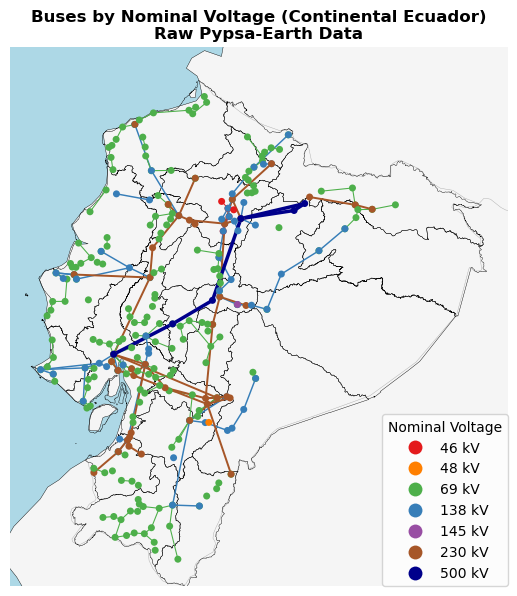

In [84]:
plot_buses_and_lines_by_voltage(
    network=networks_dict["network_original"],
    title= "Buses by Nominal Voltage (Continental Ecuador)\nRaw Pypsa-Earth Data",
    save_name= "01_EC_Grid_Original.png"
)

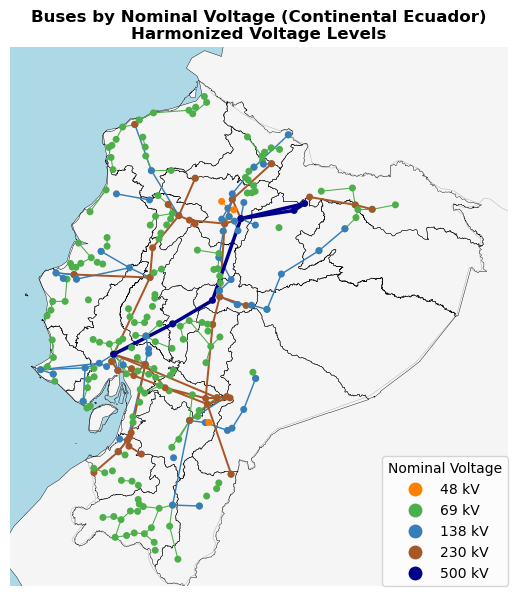

In [85]:
plot_buses_and_lines_by_voltage(
    network=networks_dict["network_snapped"],
    title= "Buses by Nominal Voltage (Continental Ecuador)\nHarmonized Voltage Levels",
    save_name= "02_EC_Grid_Snapped.png"
)

Plot the Grid W/o Orphans

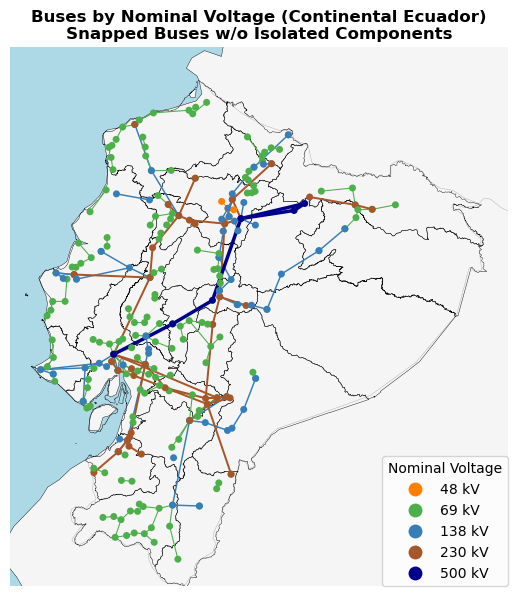

In [86]:
plot_buses_and_lines_by_voltage(
    network=networks_dict["network_base"],
    title= "Buses by Nominal Voltage (Continental Ecuador)\nSnapped Buses w/o Isolated Components",
    save_name= "03_EC_Grid_Processed.png"
)

Plot the Expanded Grid According to the Master Plan

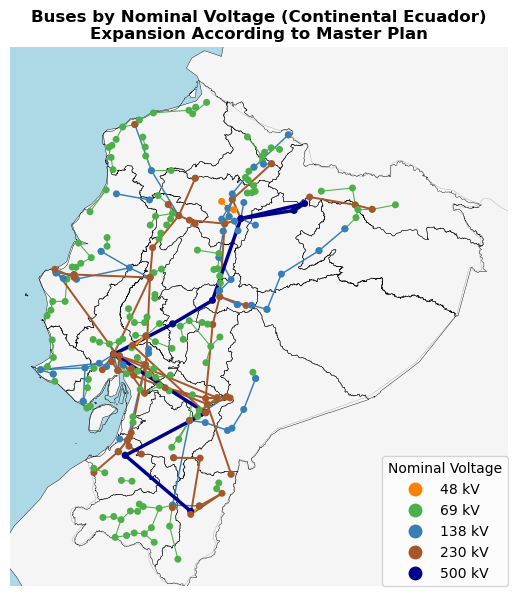

In [87]:
plot_buses_and_lines_by_voltage(
    network=networks_dict["network_prod_mix"],
    title= "Buses by Nominal Voltage (Continental Ecuador)\nExpansion According to Master Plan",
    save_name= "04_EC_Expansion.png"
)

Plotting only the Expansion Components

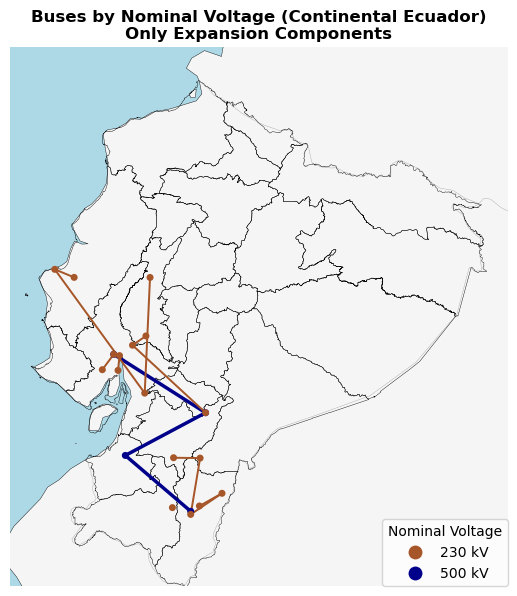

In [88]:
network_mix_exp=copy.deepcopy(networks_dict["network_prod_mix"])
network_base=copy.deepcopy(networks_dict["network_base"])

for name in list(network_base.buses.index): network_mix_exp.remove("Bus", name)

for name in list(network_base.lines.index): network_mix_exp.remove("Line", name)

for name in list(network_base.transformers.index): network_mix_exp.remove("Transformer", name)

plot_buses_and_lines_by_voltage(
    network=network_mix_exp,
    title= "Buses by Nominal Voltage (Continental Ecuador)\nOnly Expansion Components",
    save_name= "05_EC_Expansion_New.png"
)

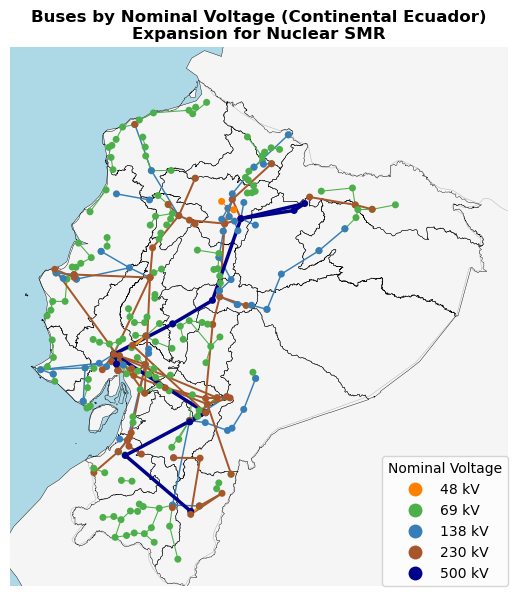

In [89]:
plot_buses_and_lines_by_voltage(
    network=networks_dict["network_nuclear"],
    title= "Buses by Nominal Voltage (Continental Ecuador)\nExpansion for Nuclear SMR",
    save_name= "06_EC_Nuclear.png"
)

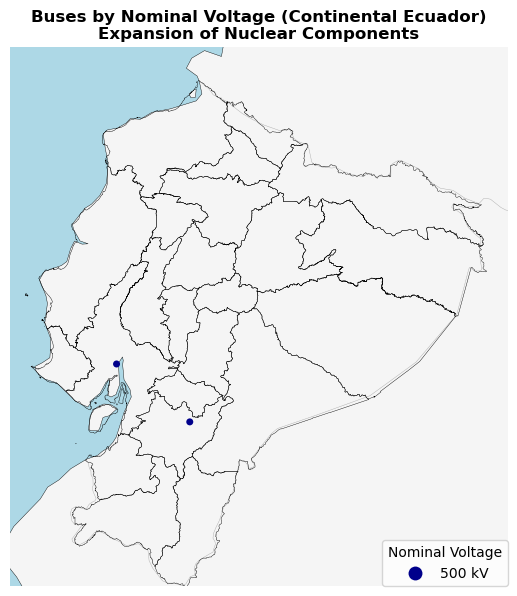

In [90]:
network_nuclear_exp=copy.deepcopy(networks_dict["network_nuclear"])
network_mix_temp=copy.deepcopy(networks_dict["network_prod_mix"])
for name in list(network_mix_temp.buses.index): network_nuclear_exp.remove("Bus", name)

for name in list(network_mix_temp.lines.index): network_nuclear_exp.remove("Line", name)

for name in list(network_mix_temp.transformers.index): network_nuclear_exp.remove("Transformer", name)

plot_buses_and_lines_by_voltage(
    network=network_nuclear_exp,
    title= "Buses by Nominal Voltage (Continental Ecuador)\nExpansion of Nuclear Components",
    save_name= "07_EC_Expansion_Extra_Nuclear.png"
)

Plot the HV (>138kV) part of the grid for the three cases


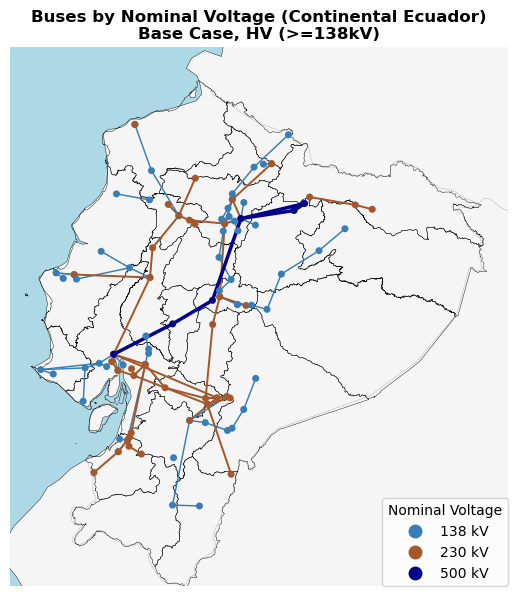

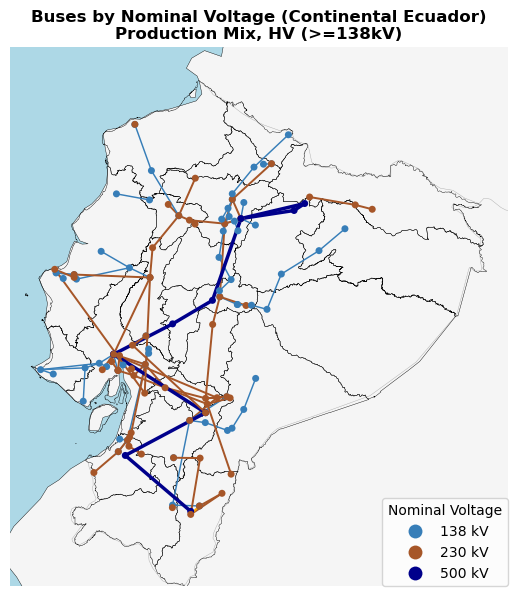

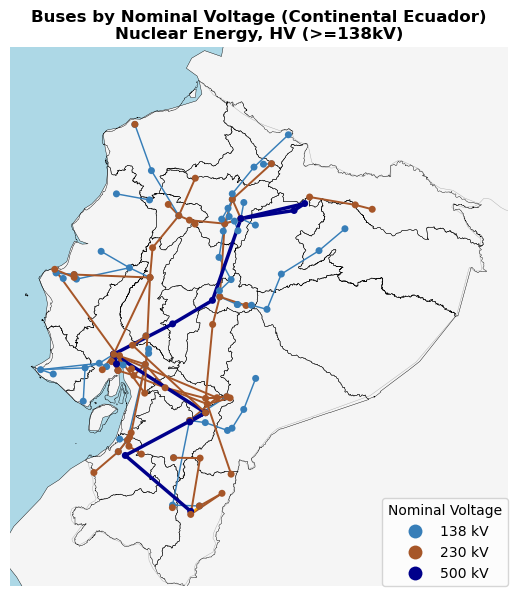

In [91]:
plot_buses_and_lines_by_voltage(
    network=networks_dict["network_base"],
    title= "Buses by Nominal Voltage (Continental Ecuador)\nBase Case, HV (>=138kV)",
    save_name= "08_EC_Base_Case_HV.png",
    lower_v_limit=120
)

plot_buses_and_lines_by_voltage(
    network=networks_dict["network_prod_mix"],
    title= "Buses by Nominal Voltage (Continental Ecuador)\nProduction Mix, HV (>=138kV)",
    save_name= "09_EC_Prod_Mix_HV.png",
    lower_v_limit=120
)


plot_buses_and_lines_by_voltage(
    network=networks_dict["network_nuclear"],
    title= "Buses by Nominal Voltage (Continental Ecuador)\nNuclear Energy, HV (>=138kV)",
    save_name= "10_EC_Nuclear_HV.png",
    lower_v_limit=120
)